In [1]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
import cv2

In [2]:
!git clone https://github.com/ancientpi3/Fellowship2022.git
from Fellowship2022.modules import basic_gan

Cloning into 'Fellowship2022'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 88 (delta 35), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (88/88), done.


In [3]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [4]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [5]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = ones((n_samples, 1))
	return X, y

In [7]:
def summarize_performance(epoch, g_model, d_model, latent_dim, n_samples=100):
	# prepare real samples
  y_real, X_real = basic_gan.generate_real_data(data_size = n_samples)
  X_real = X_real.reshape(n_samples, 28,28,1)
  y_real = y_real.reshape(n_samples, 1)
	# evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  #save_plot(x_fake, epoch)
  # save the generator model tile file
  #filename = 'generator_model_%03d.h5' % (epoch + 1)
  #g_model.save(filename)

In [8]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10, n_batch=100, real_data_size = 1000):
  bat_per_epo = int(real_data_size / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples

      y_real, X_real = basic_gan.generate_real_data(data_size = half_batch)
      X_real = X_real.reshape(half_batch, 28,28,1)
      y_real = y_real.reshape(half_batch, 1)

      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 1 == 0:
      summarize_performance(i, g_model, d_model, latent_dim)


In [9]:
latent_dim = 2
d_model = basic_gan.define_discriminator()
g_model = basic_gan.define_generator(latent_dim)
gan_model = define_gan(g_model,d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
dataset = basic_gan.generate_real_data(data_size=100)

In [11]:
real_label,real_x = dataset

In [12]:
real_x = real_x.reshape(100,28,28,1)
real_label = real_label.reshape(100,1)

In [13]:
fake_x, fake_label = generate_fake_samples(g_model,latent_dim=latent_dim, n_samples=100)

4/4 [==============================] - 11s 18ms/step


In [14]:
print(real_x.shape)
print(fake_x.shape)
print(real_label.shape)
print(fake_label.shape)

(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 1)
(100, 1)


In [15]:
train(g_model, d_model, gan_model,latent_dim)

2/2 [==============================] - 0s 60ms/step
>1, 1/10, d=0.705, g=0.816
2/2 [==============================] - 0s 4ms/step
>1, 2/10, d=0.626, g=0.970
2/2 [==============================] - 0s 5ms/step
>1, 3/10, d=0.558, g=1.140
2/2 [==============================] - 0s 5ms/step
>1, 4/10, d=0.498, g=1.328
2/2 [==============================] - 0s 5ms/step
>1, 5/10, d=0.443, g=1.531
2/2 [==============================] - 0s 5ms/step
>1, 6/10, d=0.396, g=1.748
2/2 [==============================] - 0s 5ms/step
>1, 7/10, d=0.354, g=1.976
2/2 [==============================] - 0s 5ms/step
>1, 8/10, d=0.316, g=2.211
2/2 [==============================] - 0s 5ms/step
>1, 9/10, d=0.286, g=2.448
2/2 [==============================] - 0s 5ms/step
>1, 10/10, d=0.257, g=2.680
4/4 [==============================] - 0s 3ms/step
>Accuracy real: 100%, fake: 100%
2/2 [==============================] - 0s 6ms/step
>2, 1/10, d=0.233, g=2.913
2/2 [==============================] - 0s 6ms/step
>2, 2

1/1 [==============================] - 0s 44ms/step


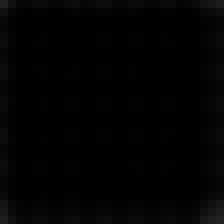

In [16]:
fake_x, fake_label = generate_fake_samples(g_model,latent_dim=latent_dim, n_samples=1)
basic_gan.show(fake_x[0])